In [1]:
# copy the lib file in the working directory and load it
from shutil import copyfile
copyfile('target/release/libising.so', 'ising.so')
import ising

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import threading
import time

In [3]:
L = 16

k_ijl = [(i,j,l) for j in range(2*L) for i in range(2*L) for l in range(3) if (i+j > L-2) and (i+j < 3*L-1)]
ijl_k = {}
for k, ijl in enumerate(k_ijl):
    ijl_k[ijl] = k

In [4]:
A = [[(0,0), (0,0), (-1,0), (0,-1)], 
            [(1,-1), (1,0), (0,0), (0,0)], 
            [(0,1), (-1,1), (0,0), (0,0)]]
B = [[1, 2, 1, 2], [2, 0, 2, 0], [0, 1, 0, 1]]

nn1 = [[(i + A[l][u][0], j + A[l][u][1], B[l][u]) for u in range(4)] for (i,j,l) in k_ijl]

def foo(i, j, l):
    if i == 2*L:
        i = 0
        j += L
    if j == 2*L:
        i += L
        j = 0
    if i+j == L-2:
        i += L
        j += L
    if i+j == 3*L-1:
        i -= L
        j -= L
    if j == -1:
        i -= L
        j = 2*L-1
    if i == -1:
        i = 2*L-1
        j -= L
    return (i, j, l)
    
nn1 = [[ijl_k[foo(i,j,l)] for (i,j,l) in n] for n in nn1]

In [5]:
H = ising.Hamiltonian([(1, nn1)])

In [6]:
n = 100  # amount of temperatures / states

# Initialize the states, compute the enegies and attribute their temperatures
xs = [np.random.randint(0, 2, size=(9 * L * L,), dtype=np.int32) * 2 - 1 for i in range(n)]
es = [H.energy(xs[i]) for i in range(n)]

bs = np.linspace(1/0.1, 1/5, n)
ts = 1 / bs

<IPython.core.display.Javascript object>


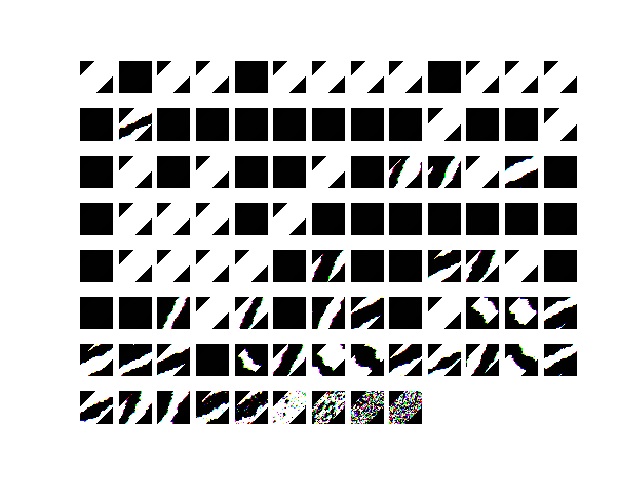

In [7]:
# This cell only makes a plot to show the evolutions of the states in real time

# compute the appropriate amount of plots to do in width
w = int(np.ceil(np.sqrt(1.5 * n)))

# create a new figure and its subplots
fig = plt.figure()
axes = [fig.add_subplot(int(np.ceil(n / w)), w, i + 1) for i in range(n)]

def image(x):
    z = np.zeros((2*L, 2*L, 3))
    for k, v in enumerate(x):
        i,j,l = k_ijl[k]
        z[j,i,l] = v
    return z

def plot(i):
    axes[i].set_axis_off()
    return axes[i].imshow(image(xs[i]), vmin=-1, vmax=1)

imgs = [plot(i) for i in range(n)]

fig.canvas.draw()

# this function sets the new data into the figure and redraw it
def replot(xs):
    for i in range(n):
        imgs[i].set_data(image(xs[i]))
    fig.canvas.draw()

In [8]:
# for debug purpose, this function measure the execution time of a portion of code

def top(text=None):
    now = time.time()
    if text:
        print("{} : {:.3f}s".format(text, now - top.past))
    top.past = now
    
top.past = time.time()

In [9]:
# Define a function that perform sweep in parallel then do parallel tempering

def sweep_swap():
    num_threads = 4
    
    # create and run one thread for each temperature
    threads = []
    for i in range(num_threads):
        # define the function that will be run by the thread (it depends on the value of i)
        def sweep():
            # perform a sweep on the states i, i+num_threads, i+2*num_threads, ...
            for j in range(i, n, num_threads):
                es[j] += H.sweep(xs[j], ts[j]) # the sweep returns the delta in energy
        
        t = threading.Thread(target=sweep) # create a new thread
        t.start() # start it
        threads.append(t)

    # wait all threads to finish
    for t in threads:
        t.join()

    # performs swaps
    for _ in range(2 * n):
        #[i, j] = np.random.choice(n, 2, replace=False) # pick randomly i != j
        i = np.random.randint(n - 1)
        j = i + 1
        if np.random.uniform() < np.exp((es[i] - es[j]) * (1 / ts[i] - 1 / ts[j])):
            # swap the states and the energies
            xs[i], xs[j] = xs[j], xs[i]
            es[i], es[j] = es[j], es[i]

In [11]:
top()
# thermalize
for _ in range(200):
    sweep_swap()

top('termalize')

m = 1000
energy = np.zeros((m, n))
magnet = np.zeros((m, n))

for i in range(m):
    top()
    
    sweep_swap()
    energy[i] = np.array(es) / (9 * L * L)
    magnet[i] = np.array([np.sum(xs[j]) for j in range(n)]) / (9 * L * L)
    
    top(str(i))
    
    if i % 10 == 0:
        replot(xs)
        top('plot')

termalize : 2.280s
0 : 0.012s
plot : 0.146s
1 : 0.017s
2 : 0.011s
3 : 0.016s
4 : 0.015s
5 : 0.014s
6 : 0.012s
7 : 0.012s
8 : 0.016s
9 : 0.011s
10 : 0.012s
plot : 0.162s
11 : 0.021s
12 : 0.012s
13 : 0.013s
14 : 0.013s
15 : 0.013s
16 : 0.013s
17 : 0.013s
18 : 0.016s
19 : 0.013s
20 : 0.013s
plot : 0.162s
21 : 0.018s
22 : 0.016s
23 : 0.012s
24 : 0.010s
25 : 0.011s
26 : 0.010s
27 : 0.011s
28 : 0.014s
29 : 0.016s
30 : 0.012s
plot : 0.184s
31 : 0.024s
32 : 0.022s
33 : 0.026s
34 : 0.025s
35 : 0.029s
36 : 0.018s
37 : 0.023s
38 : 0.026s
39 : 0.026s
40 : 0.024s
plot : 0.151s
41 : 0.018s
42 : 0.014s
43 : 0.019s
44 : 0.012s
45 : 0.012s
46 : 0.013s
47 : 0.011s
48 : 0.012s
49 : 0.014s
50 : 0.010s
plot : 0.152s
51 : 0.020s
52 : 0.012s
53 : 0.012s
54 : 0.010s
55 : 0.010s
56 : 0.012s
57 : 0.015s
58 : 0.017s
59 : 0.017s
60 : 0.013s
plot : 0.258s
61 : 0.030s
62 : 0.026s
63 : 0.023s
64 : 0.022s
65 : 0.022s
66 : 0.022s
67 : 0.021s
68 : 0.026s
69 : 0.022s
70 : 0.023s
plot : 0.212s
71 : 0.012s
72 : 0.012s
73 

In [ ]:
plt.figure()
plt.semilogx(ts, np.mean(energy, 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('energy')
plt.tight_layout()